# Fetal Nuchal Translucency Segmenter Model

In [4]:
# Imports
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
import mlflow
import pandas as pd

In [5]:
# Global constants
MLFLOW_URI = "http://localhost:8080"
BATCH_SIZE = 8 
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EARLY_STOPPING_PATIENCE = 10
CHECKPOINT_DIR = "checkpoints"
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "best_nt_segmenter.pth")
ONNX_SAVE_DIR = "onnx_exports"
MODEL_SAVE_PATH = os.path.join(ONNX_SAVE_DIR, "nt_segmenter.onnx")
RUN_NAME = f"{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}"

In [ ]:
# Logging with tensorboard and mlflow
tb_writer = SummaryWriter(log_dir='tb_logs/nt_segmenter')
mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment("nt_segmenter")

In [7]:
IMG_DIR = 'preprocessed_images'
MASK_DIR = "segmentations"

In [8]:
# Setup device
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
# check if windows is being used and try to import torch-directml
elif os.name == 'nt':
    try:
        import torch_directml
        device = torch_directml.device()
    except ImportError:
        pass
print(f"Using device: {device}")

Using device: privateuseone:0


## Step 1: Dataset Configuration

In [ ]:

# Gather and filter filenames
all_imgs = [f for f in os.listdir(IMG_DIR) if f.endswith('.png')]
valid_imgs = [
    img for img in all_imgs
    if os.path.exists(os.path.join(MASK_DIR, f"seg_{os.path.splitext(img)[0]}.png"))
]

# Split into train / test (80/20)
train_files, test_files = train_test_split(
    valid_imgs,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Build full paths lists
train_imgs  = [os.path.join(IMG_DIR,  img) for img in train_files]
train_masks = [os.path.join(MASK_DIR, f"seg_{os.path.splitext(img)[0]}.png")
               for img in train_files]

test_imgs   = [os.path.join(IMG_DIR,  img) for img in test_files]
test_masks  = [os.path.join(MASK_DIR, f"seg_{os.path.splitext(img)[0]}.png")
               for img in test_files]

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

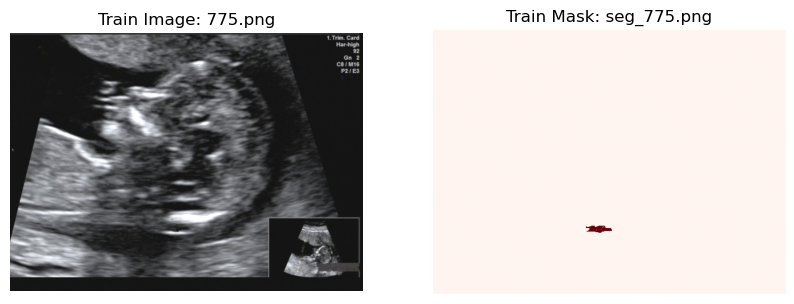

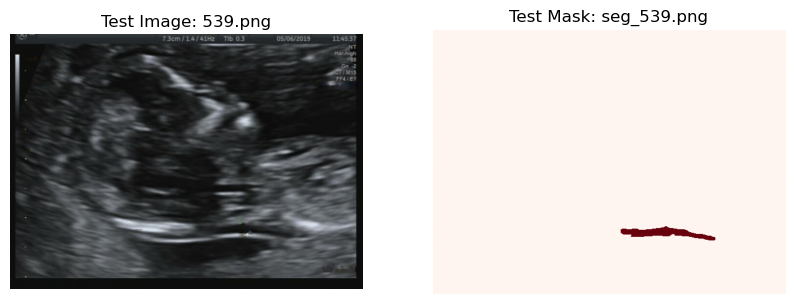

In [ ]:
# Convert to lists if they’re Paths
train_files = [f.name if hasattr(f, 'name') else f for f in train_files]
test_files  = [f.name if hasattr(f, 'name') else f for f in test_files]

# Choose random samples
train_sample = random.choice(train_files)
test_sample  = random.choice(test_files)

# Paths
train_img  = os.path.join(IMG_DIR, train_sample)
train_mask = os.path.join(MASK_DIR, f"seg_{os.path.splitext(train_sample)[0]}.png")
test_img   = os.path.join(IMG_DIR, test_sample)
test_mask  = os.path.join(MASK_DIR,  f"seg_{os.path.splitext(test_sample)[0]}.png")

def plot_pair(img_path, mask_path, title):
    img  = mpimg.imread(img_path)
    mask = mpimg.imread(mask_path)
    if mask.max() <= 1.0:
        mask = mask * 255

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img, cmap='gray')
    ax1.set_title(f"{title} Image: {os.path.basename(img_path)}")
    ax1.axis('off')

    ax2.imshow(mask, cmap='Reds')
    ax2.set_title(f"{title} Mask: {os.path.basename(mask_path)}")
    ax2.axis('off')
    plt.show()

# Display
plot_pair(train_img, train_mask, 'Train')
plot_pair(test_img, test_mask,   'Test')

In [ ]:
print(f"Number of train images: {len(train_imgs)}")
print(f"Number of train masks:  {len(train_masks)}")

print(f"Number of test images:  {len(test_imgs)}")
print(f"Number of test masks:   {len(test_masks)}")

Number of train images: 830
Number of train masks:  830
Number of test images:  208
Number of test masks:   208


In [ ]:
from collections import Counter
import cv2

In [ ]:

def get_shapes(paths):
    shapes = [cv2.imread(p, cv2.IMREAD_UNCHANGED).shape[:2] for p in paths]
    # shape[:2] is (height, width)
    return Counter(shapes)

# your four lists:
#   train_imgs, train_masks, test_imgs, test_masks

print(f"Number of train images: {len(train_imgs)}")
print(f"Train image dimensions (H×W) frequency:")
for (h, w), cnt in get_shapes(train_imgs).items():
    print(f"  {h}×{w}: {cnt}")

print(f"\nNumber of train masks: {len(train_masks)}")
print(f"Train mask dimensions (H×W) frequency:")
for (h, w), cnt in get_shapes(train_masks).items():
    print(f"  {h}×{w}: {cnt}")

print(f"\nNumber of test images: {len(test_imgs)}")
print(f"Test image dimensions (H×W) frequency:")
for (h, w), cnt in get_shapes(test_imgs).items():
    print(f"  {h}×{w}: {cnt}")

print(f"\nNumber of test masks: {len(test_masks)}")
print(f"Test mask dimensions (H×W) frequency:")
for (h, w), cnt in get_shapes(test_masks).items():
    print(f"  {h}×{w}: {cnt}")

Number of train images: 830
Train image dimensions (H×W) frequency:
  471×720: 1
  521×675: 1
  479×694: 1
  415×723: 1
  450×640: 107
  476×669: 1
  481×680: 2
  527×720: 2
  486×728: 1
  480×696: 1
  454×570: 1
  491×679: 1
  510×681: 1
  492×670: 1
  514×677: 1
  495×726: 2
  484×677: 4
  530×722: 1
  439×663: 1
  426×629: 1
  451×681: 1
  477×668: 1
  491×668: 1
  535×710: 1
  490×620: 1
  461×681: 2
  507×680: 1
  363×621: 1
  489×629: 1
  477×728: 1
  485×614: 1
  478×719: 1
  478×673: 2
  480×720: 2
  487×722: 1
  499×674: 1
  499×659: 1
  493×579: 1
  507×678: 2
  524×704: 1
  406×641: 1
  508×720: 3
  487×720: 1
  473×681: 1
  457×681: 2
  488×673: 1
  501×648: 1
  523×721: 1
  490×652: 1
  323×596: 1
  505×680: 1
  465×679: 1
  482×672: 1
  483×721: 1
  495×679: 2
  476×663: 1
  526×720: 1
  490×720: 1
  465×508: 1
  523×719: 1
  525×636: 1
  486×677: 1
  484×728: 1
  490×615: 2
  482×721: 1
  419×677: 1
  509×682: 1
  495×681: 4
  409×673: 1
  430×667: 1
  481×726: 1
  500×6

In [ ]:

class FetusSegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transforms=None):
        assert len(image_paths) == len(mask_paths), "Images and masks counts must match"
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.transforms  = transforms or T.Compose([
            T.Resize((256,256)),      # optional: down/up-sample
            T.ToTensor(),             # [0–255] → [0–1], shape [C,H,W]
        ])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load grayscale image & mask
        img  = Image.open(self.image_paths[idx]).convert('L')
        msk  = Image.open(self.mask_paths[idx]).convert('L')
        
        # Apply identical transforms
        img_t = self.transforms(img)
        msk_t = self.transforms(msk)
        
        # Optionally: binarize mask (if not already 0/1)
        msk_t = (msk_t > 0.5).float()
        
        return img_t, msk_t

# --- Transforms (you can add normalization or augmentation here) ---
TARGET_SIZE = (400, 600)  # target size for images and masks
transforms = T.Compose([
    T.Resize(TARGET_SIZE),   # keep original size
    T.ToTensor(),          # → [0,1]
])

# 1) Create datasets
train_ds = FetusSegDataset(train_imgs,  train_masks, transforms=transforms)
test_ds  = FetusSegDataset(test_imgs,   test_masks,  transforms=transforms)

# 2) Create loaders
batch_size = 4
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# 3) Quick sanity‐check
# Pull one batch and inspect shapes
imgs, masks = next(iter(train_loader))
print("Images batch:", imgs.shape)   # e.g. [8, 1, 450, 600]
print("Masks batch: ", masks.shape)  # e.g. [8, 1, 450, 600]

Images batch: torch.Size([4, 1, 400, 600])
Masks batch:  torch.Size([4, 1, 400, 600])


In [ ]:
#check the max and mean values of an image in the bach as well as the masks 
print("Max value in images batch:", imgs.max().item())  # should be ~1.0
print("Min value in images batch:", imgs.min().item())  # should be ~0.5
print("Max value in masks batch:", masks.max().item())  # should be 1.0
print("Min value in masks batch:", masks.min().item())  # should be ~0.5
# Check if the images and masks are correctly paired

Max value in images batch: 1.0
Min value in images batch: 0.0
Max value in masks batch: 1.0
Min value in masks batch: 0.0


In [ ]:
# 1) Set a batch size
batch_size = 8

# 2) Create the loaders
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,      # shuffle for training
    num_workers=2,     # adjust to your machine
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,     # no shuffle for validation
    num_workers=2,
    pin_memory=True
)

# 3) Sanity check
imgs, masks = next(iter(train_loader))
print("Train batch  images:", imgs.shape)   # [batch, 1, H, W]
print("Train batch  masks: ", masks.shape)  # [batch, 1, H, W]

Train batch  images: torch.Size([8, 1, 400, 600])
Train batch  masks:  torch.Size([8, 1, 400, 600])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:


# 1) Building blocks

class DoubleConv(nn.Module):
    """(conv ⇒ ReLU ⇒ conv ⇒ ReLU)"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch,  out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )
    def forward(self, x):
        return self.pool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        # choose upsampling method
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            mid_ch = in_ch // 2
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
            mid_ch = in_ch // 2

        self.conv = DoubleConv(in_ch, out_ch)
    
    def forward(self, x1, x2):
        # x1 is decoder input, x2 is encoder skip connection
        x1 = self.up(x1)
        # input is CHW, adjust pad if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX//2, diffX - diffX//2,
                        diffY//2, diffY - diffY//2])
        # concatenate along channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """1×1 conv to map to output channels"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

# 2) UNet assembly

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, bilinear=True):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.bilinear     = bilinear

        # encoder (contracting path)
        self.inc    = DoubleConv(in_channels, 64)
        self.down1  = Down(64, 128)
        self.down2  = Down(128, 256)
        self.down3  = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4  = Down(512, 1024 // factor)

        # decoder (expansive path)
        self.up1    = Up(1024, 512 // factor, bilinear)
        self.up2    = Up(512, 256 // factor, bilinear)
        self.up3    = Up(256, 128 // factor, bilinear)
        self.up4    = Up(128, 64, bilinear)

        # final 1x1 convolution
        self.outc   = OutConv(64, out_channels)

    def forward(self, x):
        # encoding
        x1 = self.inc(x)      # 64 channels
        x2 = self.down1(x1)   # 128
        x3 = self.down2(x2)   # 256
        x4 = self.down3(x3)   # 512
        x5 = self.down4(x4)   # 1024

        # decoding with skip connections
        x  = self.up1(x5, x4)
        x  = self.up2(x,  x3)
        x  = self.up3(x,  x2)
        x  = self.up4(x,  x1)

        logits = self.outc(x)
        return logits

In [ ]:
model  = UNet(in_channels=1, out_channels=1, bilinear=True).to(device)

In [ ]:
# x = torch.randn(1, 1, 450, 600, device=device)
# with torch.no_grad():
#     out = model(x)
# print("Input shape :", x.shape)
# print("Output shape:", out.shape)  # should be [1,1,450,600]

In [ ]:
import torch.optim as optim
from segmentation_models_pytorch.utils.metrics import IoU

In [ ]:
# Binary segmentation: logits → mask
loss_fn   = nn.BCEWithLogitsLoss()          # combines Sigmoid + BCELoss
metric_fn = IoU(threshold=0.5)              # or write your own Dice/IoU

optimizer = optim.Adam(model.parameters(), lr=1e-5)
# (Optional) a LR scheduler, e.g. ReduceLROnPlateau on val loss:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

In [20]:
from tqdm.auto import tqdm

num_epochs = 30
best_val_iou = 0.0

# Main training loop
for epoch in range(1, num_epochs+1):
    # ——— Training ———
    model.train()
    running_loss = 0.0
    train_pbar = tqdm(train_loader, desc=f'Training Epoch {epoch:02d}')
    for imgs, masks in train_pbar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss   = loss_fn(logits, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        # Update progress bar description
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    epoch_train_loss = running_loss / len(train_loader.dataset)
    
    # Log training metrics
    writer.add_scalar('Loss/train', epoch_train_loss, epoch)

    # ——— Validation ———
    model.eval()
    val_loss, val_iou = 0.0, 0.0
    val_pbar = tqdm(test_loader, desc=f'Validation Epoch {epoch:02d}')
    with torch.no_grad():
        for imgs, masks in val_pbar:
            imgs, masks = imgs.to(device), masks.to(device)
            logits       = model(imgs)
            loss         = loss_fn(logits, masks)
            val_loss    += loss.item() * imgs.size(0)
            # apply sigmoid then metric
            preds       = torch.sigmoid(logits)
            val_iou    += metric_fn(preds, masks).item() * imgs.size(0)
            # Update progress bar description
            val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    epoch_val_loss = val_loss / len(test_loader.dataset)
    epoch_val_iou  = val_iou  / len(test_loader.dataset)

    # Log validation metrics
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)
    writer.add_scalar('IoU/val', epoch_val_iou, epoch)

    # ——— Logging & Scheduler ———
    print(f"\nEpoch {epoch:02d} | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | "
          f"Val IoU: {epoch_val_iou:.4f}")
    scheduler.step(epoch_val_loss)

    # ——— Checkpointing ———
    if epoch_val_iou > best_val_iou:
        best_val_iou = epoch_val_iou
        torch.save(model.state_dict(), "best_unet.pth")
        print("  Saved new best model.")

# Close tensorboard writer
writer.close()

Validation Epoch 01: 100%|██████████| 26/26 [00:06<00:00,  3.83it/s, loss=0.0471]



Epoch 01 | Train Loss: 0.0199 | Val Loss: 0.0239 | Val IoU: 0.5347
  Saved new best model.


Validation Epoch 02: 100%|██████████| 26/26 [00:06<00:00,  3.81it/s, loss=0.0391]



Epoch 02 | Train Loss: 0.0181 | Val Loss: 0.0227 | Val IoU: 0.5650
  Saved new best model.


Validation Epoch 03: 100%|██████████| 26/26 [00:06<00:00,  3.84it/s, loss=0.0384]



Epoch 03 | Train Loss: 0.0166 | Val Loss: 0.0218 | Val IoU: 0.5720
  Saved new best model.


Validation Epoch 04: 100%|██████████| 26/26 [00:06<00:00,  3.81it/s, loss=0.0420]



Epoch 04 | Train Loss: 0.0145 | Val Loss: 0.0210 | Val IoU: 0.5860
  Saved new best model.


Validation Epoch 05: 100%|██████████| 26/26 [00:06<00:00,  3.86it/s, loss=0.0443]



Epoch 05 | Train Loss: 0.0135 | Val Loss: 0.0209 | Val IoU: 0.5690


Validation Epoch 06: 100%|██████████| 26/26 [00:06<00:00,  3.77it/s, loss=0.0436]



Epoch 06 | Train Loss: 0.0128 | Val Loss: 0.0206 | Val IoU: 0.5573


Validation Epoch 07: 100%|██████████| 26/26 [00:06<00:00,  3.84it/s, loss=0.0436]



Epoch 07 | Train Loss: 0.0121 | Val Loss: 0.0213 | Val IoU: 0.5124


Validation Epoch 08: 100%|██████████| 26/26 [00:06<00:00,  3.85it/s, loss=0.0472]



Epoch 08 | Train Loss: 0.0114 | Val Loss: 0.0211 | Val IoU: 0.5630


Validation Epoch 09: 100%|██████████| 26/26 [00:06<00:00,  3.83it/s, loss=0.0432]



Epoch 09 | Train Loss: 0.0109 | Val Loss: 0.0201 | Val IoU: 0.5761


Validation Epoch 10: 100%|██████████| 26/26 [00:06<00:00,  3.76it/s, loss=0.0449]



Epoch 10 | Train Loss: 0.0101 | Val Loss: 0.0203 | Val IoU: 0.5279


Validation Epoch 11: 100%|██████████| 26/26 [00:07<00:00,  3.68it/s, loss=0.0437]



Epoch 11 | Train Loss: 0.0096 | Val Loss: 0.0205 | Val IoU: 0.5657


Validation Epoch 12: 100%|██████████| 26/26 [00:06<00:00,  3.82it/s, loss=0.0451]



Epoch 12 | Train Loss: 0.0092 | Val Loss: 0.0202 | Val IoU: 0.5309


Validation Epoch 13: 100%|██████████| 26/26 [00:06<00:00,  3.81it/s, loss=0.0422]



Epoch 13 | Train Loss: 0.0087 | Val Loss: 0.0190 | Val IoU: 0.5714


Validation Epoch 14: 100%|██████████| 26/26 [00:06<00:00,  3.89it/s, loss=0.0457]



Epoch 14 | Train Loss: 0.0083 | Val Loss: 0.0195 | Val IoU: 0.5926
  Saved new best model.


Validation Epoch 15: 100%|██████████| 26/26 [00:06<00:00,  3.92it/s, loss=0.0450]



Epoch 15 | Train Loss: 0.0079 | Val Loss: 0.0198 | Val IoU: 0.5717


Validation Epoch 16: 100%|██████████| 26/26 [00:06<00:00,  3.90it/s, loss=0.0483]



Epoch 16 | Train Loss: 0.0075 | Val Loss: 0.0200 | Val IoU: 0.5353


Validation Epoch 17: 100%|██████████| 26/26 [00:06<00:00,  3.95it/s, loss=0.0463]



Epoch 17 | Train Loss: 0.0073 | Val Loss: 0.0182 | Val IoU: 0.5867


Validation Epoch 18: 100%|██████████| 26/26 [00:06<00:00,  3.92it/s, loss=0.0451]



Epoch 18 | Train Loss: 0.0068 | Val Loss: 0.0186 | Val IoU: 0.5921


Validation Epoch 19: 100%|██████████| 26/26 [00:06<00:00,  3.98it/s, loss=0.0443]



Epoch 19 | Train Loss: 0.0064 | Val Loss: 0.0186 | Val IoU: 0.5742


Validation Epoch 20: 100%|██████████| 26/26 [00:06<00:00,  3.98it/s, loss=0.0484]



Epoch 20 | Train Loss: 0.0060 | Val Loss: 0.0189 | Val IoU: 0.5555


Validation Epoch 21: 100%|██████████| 26/26 [00:06<00:00,  3.96it/s, loss=0.0483]



Epoch 21 | Train Loss: 0.0057 | Val Loss: 0.0188 | Val IoU: 0.5676


Validation Epoch 22: 100%|██████████| 26/26 [00:06<00:00,  3.96it/s, loss=0.0462]



Epoch 22 | Train Loss: 0.0053 | Val Loss: 0.0186 | Val IoU: 0.5886


Validation Epoch 23: 100%|██████████| 26/26 [00:06<00:00,  3.92it/s, loss=0.0472]



Epoch 23 | Train Loss: 0.0050 | Val Loss: 0.0192 | Val IoU: 0.5754


Validation Epoch 24: 100%|██████████| 26/26 [00:06<00:00,  3.97it/s, loss=0.0498]



Epoch 24 | Train Loss: 0.0049 | Val Loss: 0.0198 | Val IoU: 0.5804


Validation Epoch 25: 100%|██████████| 26/26 [00:06<00:00,  3.95it/s, loss=0.0485]



Epoch 25 | Train Loss: 0.0047 | Val Loss: 0.0193 | Val IoU: 0.5797


Validation Epoch 26: 100%|██████████| 26/26 [00:06<00:00,  3.97it/s, loss=0.0483]



Epoch 26 | Train Loss: 0.0046 | Val Loss: 0.0196 | Val IoU: 0.5858


Validation Epoch 27: 100%|██████████| 26/26 [00:06<00:00,  3.97it/s, loss=0.0499]



Epoch 27 | Train Loss: 0.0044 | Val Loss: 0.0200 | Val IoU: 0.5852


Validation Epoch 28: 100%|██████████| 26/26 [00:06<00:00,  3.93it/s, loss=0.0490]



Epoch 28 | Train Loss: 0.0044 | Val Loss: 0.0201 | Val IoU: 0.5781


Validation Epoch 29: 100%|██████████| 26/26 [00:06<00:00,  3.92it/s, loss=0.0502]



Epoch 29 | Train Loss: 0.0043 | Val Loss: 0.0204 | Val IoU: 0.5803


Validation Epoch 30: 100%|██████████| 26/26 [00:06<00:00,  3.88it/s, loss=0.0500]


Epoch 30 | Train Loss: 0.0042 | Val Loss: 0.0204 | Val IoU: 0.5831


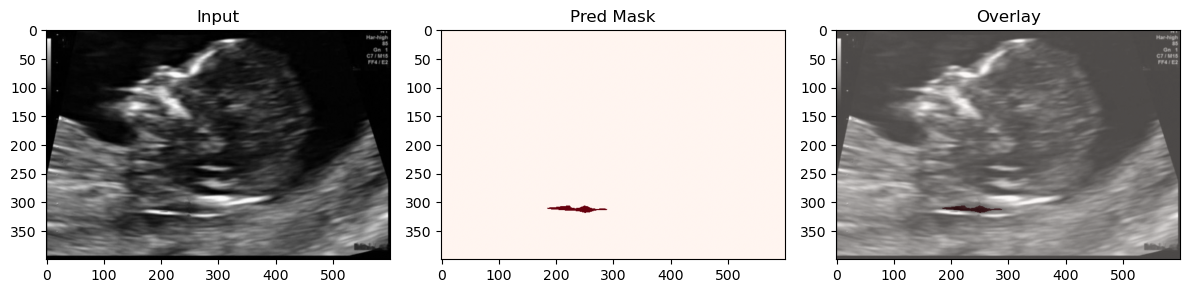

In [ ]:
# load best weights
model.load_state_dict(torch.load("best_unet.pth"))
model.eval()

# single-image inference example
img, _ = next(iter(test_loader))  # take one batch
img = img.to(device)
with torch.no_grad():
    logits = model(img)
    probs  = torch.sigmoid(logits)  # [B,1,H,W]
    preds  = (probs > 0.5).float()

# visualize first sample
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img[0,0].cpu(), cmap='gray'); plt.title("Input")
plt.subplot(1,3,2); plt.imshow(preds[0,0].cpu(), cmap='Reds'); plt.title("Pred Mask")
plt.subplot(1,3,3); plt.imshow(img[0,0].cpu(), cmap='gray'); 
plt.imshow(preds[0,0].cpu(), cmap='Reds', alpha=0.3); plt.title("Overlay")
plt.tight_layout(); plt.show()


# Inference

In [ ]:
import torch.onnx
import onnxruntime as ort

In [ ]:
onnx_path = "onnx_exports/unet_fetus_segmentation.onnx"

Model exported to unet_fetus_segmentation.onnx
ONNX model is valid.


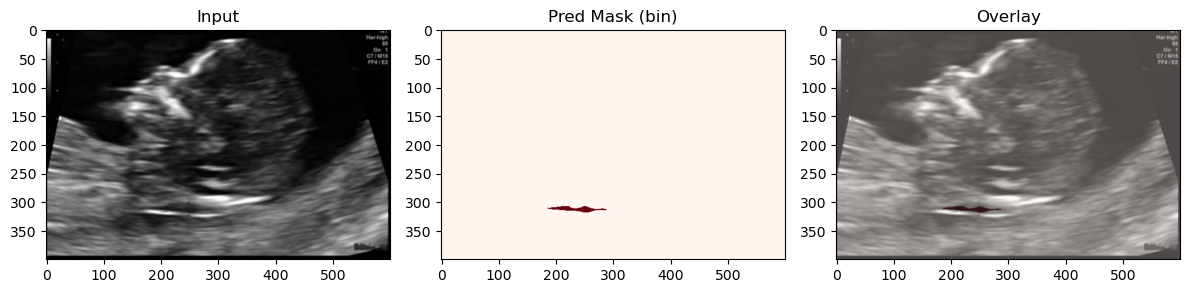

In [ ]:
# Save model as onnx
torch.onnx.export(
    model,
    img,  # dummy input
    onnx_path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},  # variable batch size
        'output': {0: 'batch_size'}
    }
)
print(f"Model exported to {onnx_path}")

In [ ]:
import onnx
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print("ONNX model is valid.")
# Visualize outputs like before
import onnxruntime as ort
ort_session = ort.InferenceSession(onnx_path)
# Run inference
ort_inputs = {ort_session.get_inputs()[0].name: img.cpu().numpy()}
ort_outputs = ort_session.run(None, ort_inputs)
# Convert outputs to tensors
ort_preds = torch.tensor(ort_outputs[0])
# Binarize predictions using threshold 0.5
ort_preds_bin = (ort_preds > 0.5).float()
# Visualize first sample
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img[0,0].cpu(), cmap='gray'); plt.title("Input")
plt.subplot(1,3,2); plt.imshow(ort_preds_bin[0,0].cpu(), cmap='Reds'); plt.title("Pred Mask (bin)")
plt.subplot(1,3,3); plt.imshow(img[0,0].cpu(), cmap='gray');
plt.imshow(ort_preds_bin[0,0].cpu(), cmap='Reds', alpha=0.3); plt.title("Overlay")
plt.tight_layout(); plt.show()